# Shopee NDSC 2020

## Team : PelajarHsinchu

- 🔭 Farhan Tandia [LinkedIn](https://www.linkedin.com/in/mfarhantandia/)
- ⚡ Ivan Surya Hutomo [LinkedIn](https://www.linkedin.com/in/ivan-surya-hutomo-b5746713a/)
- 🌱 Mahdin Rohmatillah [LinkedIn](https://www.linkedin.com/in/mahdin-rohmatillah-99596799/)
- 🥅 Martin Dominikus [LinkedIn](https://www.linkedin.com/in/martindominikus/)

In [1]:
'''Import all required Dependencies'''

from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D,Multiply, Dropout, Subtract, Add,  BatchNormalization,Lambda,GlobalAveragePooling2D,GlobalMaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers

from keras.regularizers import l2
from keras import backend as K
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB3, EfficientNetB6
from tensorflow.keras.applications import VGG16
import tensorflow_addons as tfa

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Flatten, Concatenate,  Dropout, Conv2D, BatchNormalization, MaxPool2D, Activation, Dense


In [2]:
'''Load Training Data'''

df = pd.read_csv("new_training_set.csv", dtype=str)

In [3]:
df.head() 

,Unnamed: 0,title_1,image_1,title_2,image_2,Label
0,0,Johnson’s ® Top to Toe Hair & Body Bath 500ml,fdff8b9b8229da091dd7d070aae05f81.jpg,Johnson's cottontouch top to toe hair & body b...,41e191742760932598c7bd201e5dad47.jpg,0
1,1,Sandal Humble,906cc44f0be72d4e767669b5b63e3a17.jpg,Sandal Humble Glass - Glanzton,7a556b836bfdd08ea592216440524a34.jpg,0
2,2,PROMO LIKUID LIKUIT LIQUIT BABY POD LIQUID SAL...,475c26635de18b9f93032400732ff336.jpg,Voporizer Liquit - Likuit - Likuid - Liquid Pr...,ace93bec689f3f1565800c500a8341fa.jpg,0
3,3,6 Pasang / Set Anting Tusuk Bentuk Lingkaran A...,e630997f6217555d6026547ad1c15f0b.jpg,Subei 6 Pasang / Set Anting Tusuk Boho Bohemia...,31abbc176b09f5bd1728cfc3ecbbfb9c.jpg,0
4,4,ROREC NATURAL SKIN CARE MASK ROREC SHEET MASK ...,a27d11700a7902febd039dc3a96f10f2.jpg,Rorec 86 Natural Skin Care Shert Mask All Variant,813ad9dd638c10f1765db9dde20c9e42.jpg,1


In [4]:
'''Know data distribution between positive and negative values'''

neg, pos = np.bincount(df['Label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 10181
    Positive: 5844 (57.40% of total)



## Train the Data

In [5]:
df['image_1']

0        fdff8b9b8229da091dd7d070aae05f81.jpg
1        906cc44f0be72d4e767669b5b63e3a17.jpg
2        475c26635de18b9f93032400732ff336.jpg
3        e630997f6217555d6026547ad1c15f0b.jpg
4        a27d11700a7902febd039dc3a96f10f2.jpg
                         ...                 
10176    08f5ba211a48e9b66bbf0d0105272efb.jpg
10177    855daa89bf4f31cec0f40b144cdb283e.jpg
10178    9525365b5b15af5855abf9daf03da8b4.jpg
10179    a245f49fdc9a03655d98e6a22a89cb7d.jpg
10180    b53a42dc8c7642798a55f1f48834933f.jpg
Name: image_1, Length: 10181, dtype: object

In [6]:
'''Convert training data from csv to train generator'''

datagen=ImageDataGenerator(validation_split = 0.2)
train_generator1=datagen.flow_from_dataframe(
dataframe=df,
directory="training_img/training_img",
x_col="image_1",
y_col="Label",
subset="training",
batch_size=11000,
shuffle = False,
class_mode='binary',
target_size=(100,100))

train_generator2=datagen.flow_from_dataframe(
dataframe=df,
directory="training_img/training_img",
x_col="image_2",
y_col="Label",
subset="training",
batch_size=11000,
shuffle = False,
class_mode='binary',
target_size=(100,100))

Found 8145 validated image filenames belonging to 2 classes.
Found 8145 validated image filenames belonging to 2 classes.


In [7]:
'''Split training data from csv to validation generator'''


valid_generator1=datagen.flow_from_dataframe(
dataframe=df,
directory="training_img/training_img",
x_col="image_1",
y_col="Label",
subset="validation",
batch_size=2036,
shuffle = False,
class_mode='binary',
target_size=(100,100))

valid_generator2=datagen.flow_from_dataframe(
dataframe=df,
directory="training_img/training_img",
x_col="image_2",
y_col="Label",
subset="validation",
batch_size=2036,
shuffle = False,
class_mode='binary',
target_size=(100,100))

Found 2036 validated image filenames belonging to 2 classes.
Found 2036 validated image filenames belonging to 2 classes.


In [8]:
'''Extract training data and label from generator'''
x_train1, y_train = next(train_generator1)
x_train2, y_train = next(train_generator2)
x_train1 = x_train1.astype('float32')
x_train2 = x_train2.astype('float32')
y_train = y_train.astype('uint8')
input_image_shape = (x_train1.shape[1], x_train1.shape[2], 3)


'''Extract validation data and label from generator'''
x_valid1, y_val = next(valid_generator1)
x_valid2, y_val = next(valid_generator2)
x_valid1 = x_valid1.astype('float32')
x_valid2 = x_valid2.astype('float32')
y_val = y_val.astype('uint8')

In [9]:
''' Add Data Augmentation to training data and validation'''
datagen=ImageDataGenerator(zoom_range=0.1,rotation_range=10,validation_split=0.2)

train_generator1=datagen.flow_from_dataframe(
dataframe=df,
directory="training_img/training_img",
x_col="image_1",
y_col="Label",
subset="training",
batch_size=10000,
shuffle = False,
class_mode='binary',
target_size=(100,100))

train_generator2=datagen.flow_from_dataframe(
dataframe=df,
directory="training_img/training_img",
x_col="image_2",
y_col="Label",
subset="training",
batch_size=10000,
shuffle = False,
class_mode='binary',
target_size=(100,100))

Found 8145 validated image filenames belonging to 2 classes.
Found 8145 validated image filenames belonging to 2 classes.


In [10]:
valid_generator1=datagen.flow_from_dataframe(
dataframe=df,
directory="training_img/training_img",
x_col="image_1",
y_col="Label",
subset="validation",
batch_size=2036,
shuffle = False,
class_mode='binary',
target_size=(100,100))

valid_generator2=datagen.flow_from_dataframe(
dataframe=df,
directory="training_img/training_img",
x_col="image_2",
y_col="Label",
subset="validation",
batch_size=2036,
shuffle = False,
class_mode='binary',
target_size=(100,100))

Found 2036 validated image filenames belonging to 2 classes.
Found 2036 validated image filenames belonging to 2 classes.


In [11]:
x_train11, y_train1 = next(train_generator1)
x_train21, y_train1 = next(train_generator2)
x_train11 = x_train11.astype('float32')
x_train21 = x_train21.astype('float32')
y_train1 = y_train1.astype('uint8')

x_valid11, y_val1 = next(valid_generator1)
x_valid21, y_val1 = next(valid_generator2)
x_valid11 = x_valid11.astype('float32')
x_valid21 = x_valid21.astype('float32')
y_val1 = y_val1.astype('uint8')



In [12]:
'''Concate original data and augmented data'''
xtrain_1 = np.concatenate((x_train1,x_train11),axis=0)
xtrain_2 = np.concatenate((x_train2,x_train21),axis=0)
y_train = np.concatenate((y_train1,y_train1))

xvalid_1 = np.concatenate((x_valid1,x_valid11),axis=0)
xvalid_2 = np.concatenate((x_valid2,x_valid21),axis=0)
y_val = np.concatenate((y_val1,y_val1))

In [13]:
'''Create siamese network'''

def get_siamese_model(input_shape):
  
    input_1 = Input(input_shape)
    input_2 = Input(input_shape)
    
   
    base_model = EfficientNetB6(weights='imagenet', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAveragePooling2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAveragePooling2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    x = Concatenate(axis=-1)([x4, x3])

    x = Dense(256, activation="relu")(x)
    x = Dropout(0.05)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['AUC'], optimizer=tfa.optimizers.LazyAdam(0.001))

    model.summary()
    return model

model = get_siamese_model((100, 100, 3))
# model.load_weights('Checkpoint_NovoGrad_30Epochs_ValAuc9238_27 Nov 2020_Weight.h5') #Load weight from precompetition checkpoint
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb6 (Functional)     (None, None, None, 2 40960143    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2304)         0           efficientnetb6[0][0]  

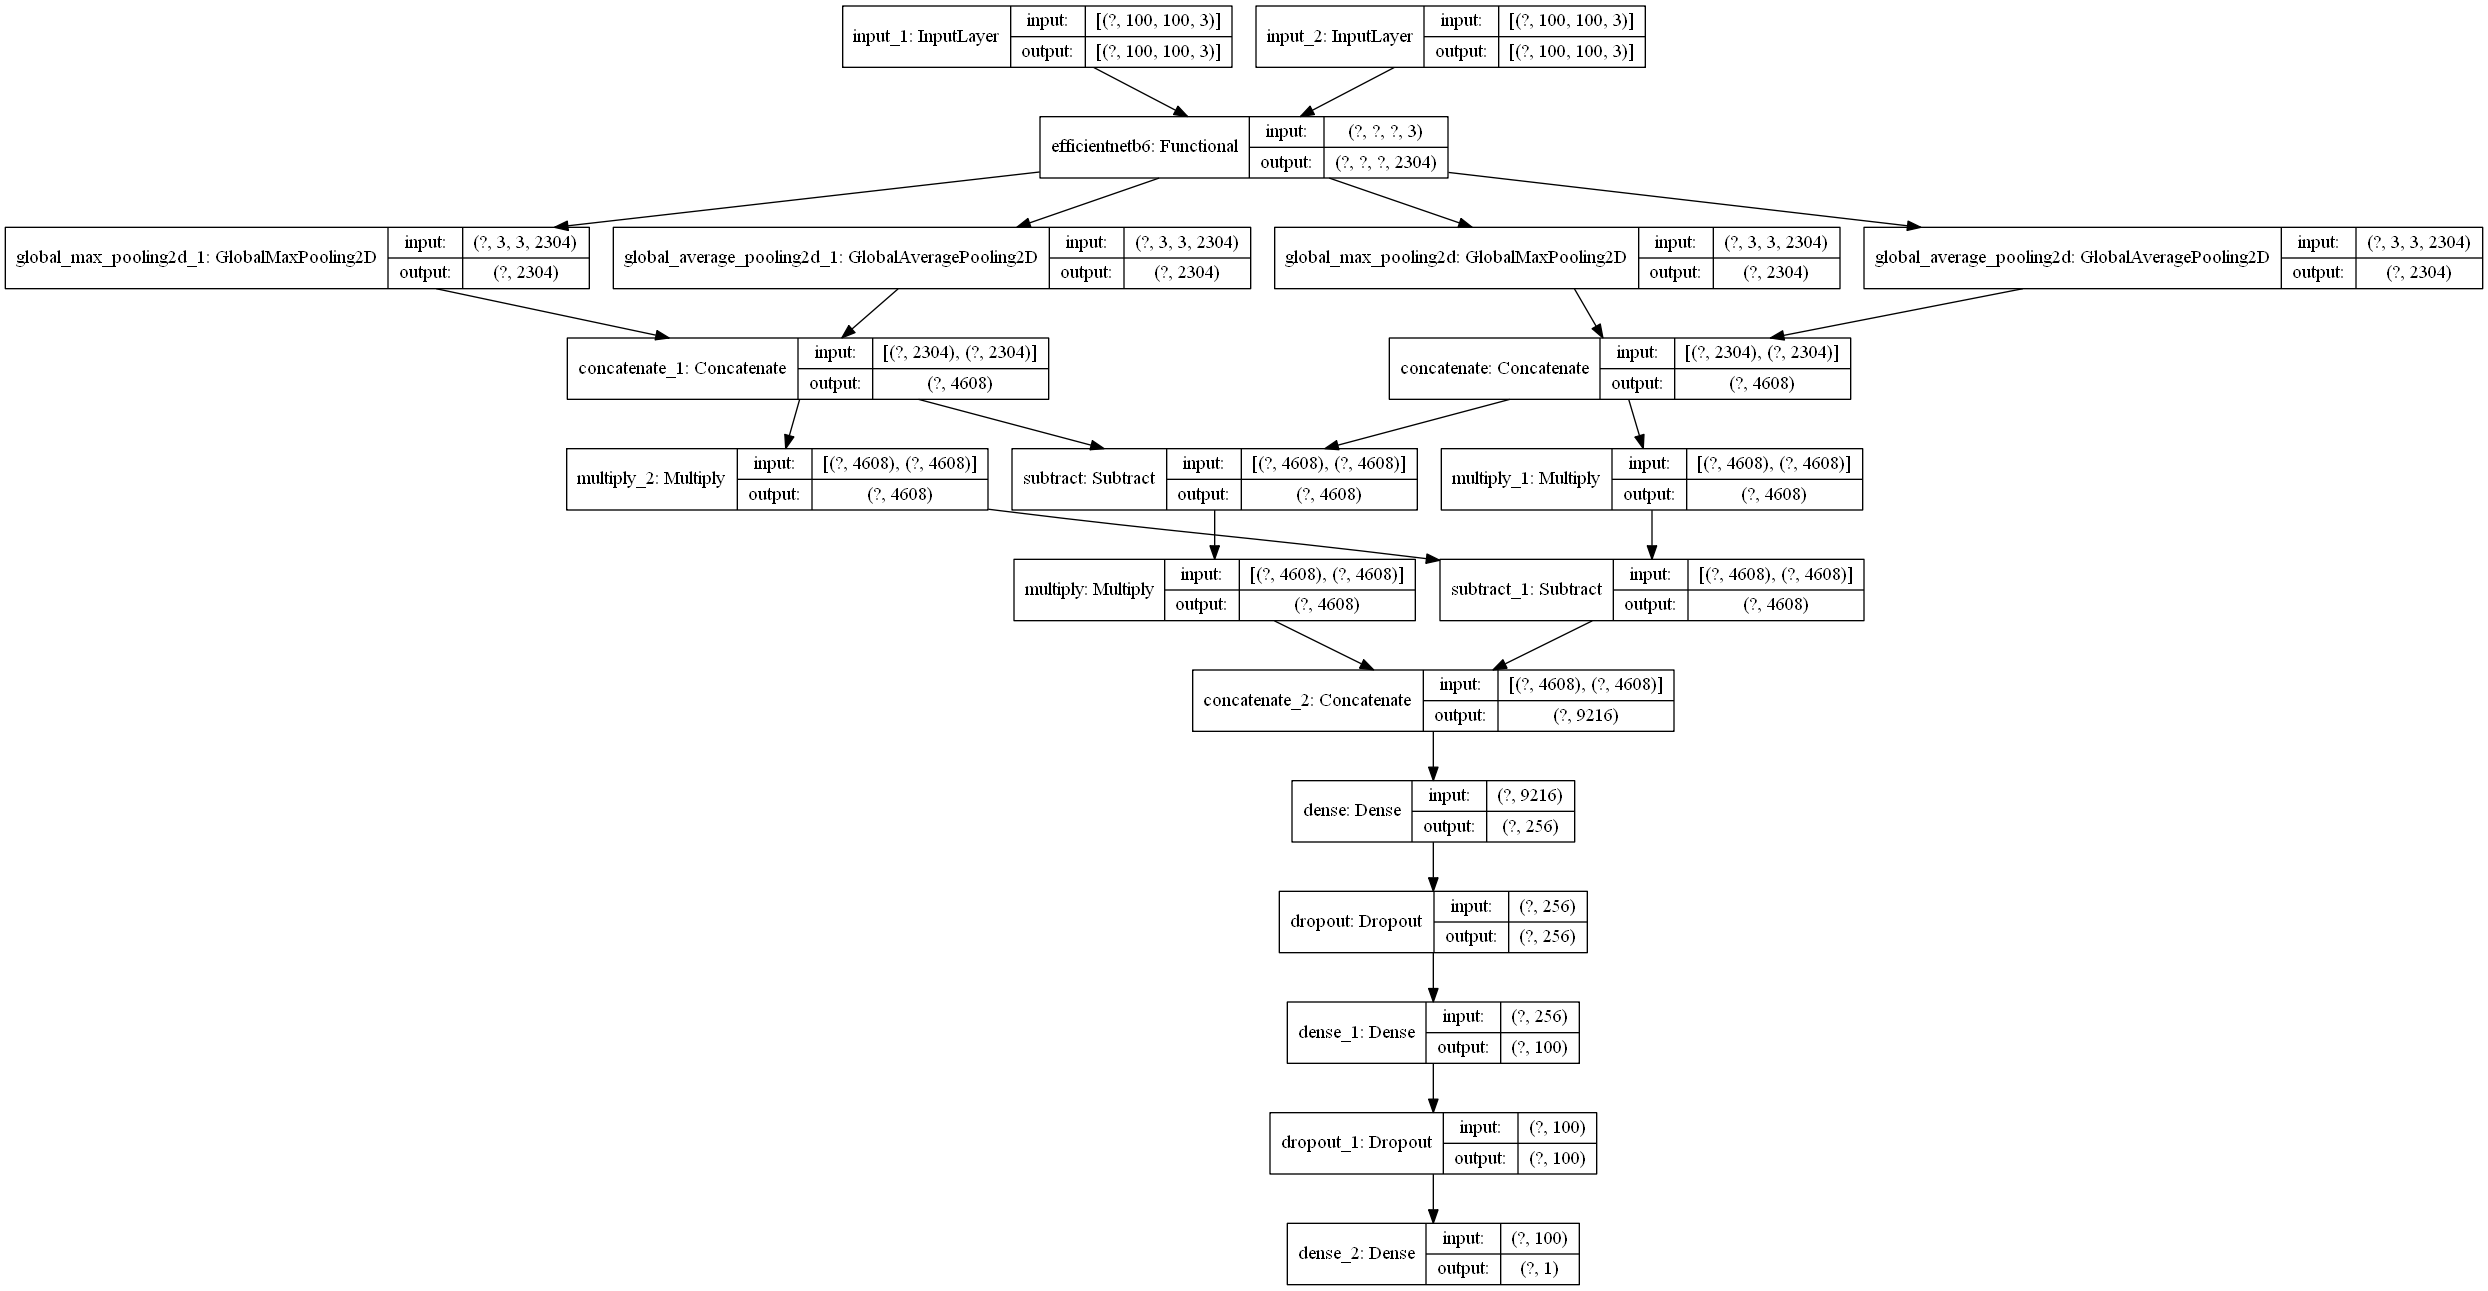

In [14]:
'''Show model architecture image'''

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
'''Start training the model'''

filepath = 'best_model_ndsc.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# stop = EarlyStopping(monitor='val_loss', patience =3,
#                       verbose=1, mode='auto', baseline=None, 
#                       restore_best_weights=False)

callbacks = [checkpoint]

history = model.fit([xtrain_1,xtrain_2], y_train, validation_data=([xvalid_1,xvalid_2], y_val),
          epochs=60,shuffle=True,
          batch_size=4,callbacks=callbacks)

Epoch 1/60
4073/4073 [==============================] - ETA: 0s - loss: 0.7007 - auc: 0.5498
Epoch 00001: val_loss improved from inf to 1.25585, saving model to best_model_ndsc.hdf5
4073/4073 [==============================] - 345s 85ms/step - loss: 0.7007 - auc: 0.5498 - val_loss: 1.2559 - val_auc: 0.6121
Epoch 2/60
4073/4073 [==============================] - ETA: 0s - loss: 0.6926 - auc: 0.4989
Epoch 00002: val_loss improved from 1.25585 to 0.68239, saving model to best_model_ndsc.hdf5
4073/4073 [==============================] - 340s 83ms/step - loss: 0.6926 - auc: 0.4989 - val_loss: 0.6824 - val_auc: 0.6730
Epoch 3/60
4073/4073 [==============================] - ETA: 0s - loss: 0.6906 - auc: 0.5013
Epoch 00003: val_loss did not improve from 0.68239
4073/4073 [==============================] - 342s 84ms/step - loss: 0.6906 - auc: 0.5013 - val_loss: 4890.8374 - val_auc: 0.5860
Epoch 4/60
4073/4073 [==============================] - ETA: 0s - loss: 0.6883 - auc: 0.5139
Epoch 00004: v

KeyboardInterrupt: 

## Save Weight

In [16]:
model.save_weights("Checkpoint_NovoGrad_90Epochs_ValAuc9238_27 Nov 2020_Weight.h5")

## Predict Test

In [17]:
model = load_model('best_model_triplet.hdf5')

In [18]:
df_test = pd.read_csv("new_test_sample.csv", dtype=str)

In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  207 non-null    object
 1   title_1     207 non-null    object
 2   image_1     207 non-null    object
 3   title_2     207 non-null    object
 4   image_2     207 non-null    object
dtypes: object(5)
memory usage: 8.2+ KB


In [20]:
img_path = "sample_img/sample_img/"
from tensorflow.keras.preprocessing import image

prediction=[]
for i,j in zip(df_test['image_1'],df_test['image_2']):
    img1 = image.load_img(img_path+i, target_size=(100,100))
    img_data1 = image.img_to_array(img1)
    img_data1 = np.expand_dims(img_data1, axis=0)
    img2 = image.load_img(img_path+j, target_size=(100,100))
    img_data2 = image.img_to_array(img2)
    img_data2 = np.expand_dims(img_data2, axis=0)
    img_identity = model.predict([img_data1, img_data2])
    
    if img_identity >0.6: 
        img_identity=1
    else : img_identity=0
        
    prediction.append(img_identity)
    

In [21]:
df_result = pd.DataFrame() 
df_result['Label']=prediction
df_result.index.names = ['pair_index']
df_result.to_csv(r'submission_b6.csv',index=True)
